# Predicting House Prices
As my first dive into modeling, my goal for this notebook is to predict house prices based on a Kaggle dataset of house attributes. This analysis will employ a few different models and will also serve as a discussion on strengths and weakness of the models used.

In [1]:
from datetime import datetime
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, normalize
import sklearn.feature_selection as fs
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor

from IPython.display import Markdown as md
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
df = pd.read_csv('train.csv')
Y = df['SalePrice']
df = df.drop(['SalePrice'], axis=1)

## Data Exploration I

Upon doing a quick inspection of the data, I've devised with the following feature handling strategy: 
- variables with less than 20 unique values will be treated as categorical features, with the exception of
    - PoolArea
- the following features have more than 20 distinct values but will be treated as categorical
    - Neighborhood
- the following features have less than 20 unique values, but will more appropriately be treated as continuous features
    - BsmtFullBath
    - BsmtHalfBath
    - FullBath
    - HalfBath
    - BedroomAbvGr
    - KitchenAbvGr
    - TotRmsAbvGrd
    - Fireplaces
    - GarageCars
    - MoSold

In [3]:
not_converted = []
for col in df.columns:
    if (len(df[col].value_counts()) < 20):
        if col != 'PoolArea':
            df[col] = df[col].astype('category')
#             print(col + ' converted to Category')
    else:
        not_converted.append(col)
        
# Categorical variables that have more than 20 distinct values.
df['Neighborhood'] = df['Neighborhood'].astype('category')

# Variables with less than 20 distinct values, that are not categorical. They contain counts, and 
# will be treated as continuous/numeric.
to_convert = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
              'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
              'Fireplaces', 'GarageCars', 'YrSold']

for col in to_convert:
    # convert cols back to int. 
    df[col] = df[col].astype(int)
    
# Note to self - think about how to encode the cyclic 'month' variable

Observations: 
   - The variables that are approximately normally distributed or have a skew, tend to be related to square footage.
   - There are a handful of discrete numerical variables representing counts
   - There are about 9 variables that look like they have a very low variability in information ie. have a high percentage of one value.    

## Data Cleaning


### High percentage of NAs

Identifying variables with more than some percentage of NAs

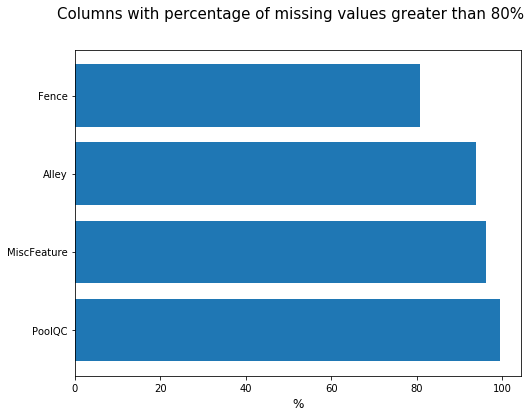

In [4]:
thresh = .8
nulls = df.isna().sum()

fig = plt.figure(figsize=(8, 6))
plt.barh(nulls[nulls > df.shape[0]*thresh].sort_values(ascending=False).index, 
         (nulls[nulls > df.shape[0]*thresh].sort_values(ascending=False)/df.shape[0]*100).values)
fig.suptitle('Columns with percentage of missing values greater than 80%', fontsize=15)
plt.xlabel('%', fontsize=12)
plt.show();

This plot suggests we should drop Alley, PoolQC, Fence, MiscFeature because they are over 80% null.
Upon looking at the data dict however, you'll see that the NAs represent the case where a house does not have a given feature, and are not actually `nulls`. 
Let this be a reminder to understand what the data represents.

### Fill missing values

In [5]:
# Separate out columns by data type to fill in missing values
integer_columns = df.select_dtypes(include=[np.int64, np.float64])
categorical_columns = df[df.select_dtypes(include=['category']).columns.union(['Id'])]

# Interpolate the two integer fields using linear interpolation
integer_columns = integer_columns.interpolate()

# Handling the two fields where the NaNs do not correspond to a known value.
# Fields 'Electrical' and "MasVnrType" have 8 and 1 missing values respectively. Since these are two fields
# where the NaN does not correspond to a value, and since there are so few records, we're dropping those.
categorical_columns = categorical_columns[~categorical_columns['Electrical'].isna()]
categorical_columns = categorical_columns[~categorical_columns['MasVnrType'].isna()]

# adding 'None' category to categorical fields, and then replacing NaN with 'None' so the records can be used in models
def add_category(df, col):
    df[col].cat.add_categories('None', inplace=True)

null_categorical = categorical_columns.isna().sum().sort_values(ascending=False).reset_index()
null_categorical = null_categorical[null_categorical['index'] != 'Id']
for index, row in null_categorical.iterrows():
    if row[0] > 0:
        add_category(categorical_columns, row['index'])
        categorical_columns[row['index']] = categorical_columns[row['index']].fillna(value='None')
        
processed_df = integer_columns.join(categorical_columns.set_index('Id'), on='Id').drop(['Id'], axis=1)

### Split data into Train, Test, Validation

In [6]:
X = pd.get_dummies(processed_df, drop_first=True)

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, train_size=.8, random_state=10)
test_X, val_X, test_Y, val_Y = train_test_split(test_X, test_Y, train_size=.8, random_state=10)

/Users/aditinabar/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Predicting with linear models

In [7]:
# perform standardization of the data
# Center the data so the mean = 0, and stdev = 1
scalar = StandardScaler()
X_standardized = scalar.fit_transform(train_X)

# normalizing using the L2 norm 
X_scaled = normalize(X_standardized, norm='l2')

/Users/aditinabar/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/aditinabar/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [8]:
# fit linear regression on X (original with dummy variables for categorical)
reg_lm_raw = lm.LinearRegression().fit(train_X, train_Y)
print('Prediction score of simple linear regression on raw data: ', reg_lm_raw.score(train_X, train_Y), '\n')

# fit linear regression on standardized and normalized data
reg_lm_scaled = lm.LinearRegression().fit(X_scaled, train_Y)
print('Prediction score of simple linear regression on scaled and normalized data: ', reg_lm_scaled.score(X_scaled, train_Y))

Prediction score of simple linear regression on raw data:  0.943140738526764 

Prediction score of simple linear regression on scaled and normalized data:  0.9187416834005794


Scaling and normalizing the data did not yield a better prediction accuracy for the simple linear regression, but will be necessary for additional models used below. We'll primarily use X_scaled going forward.


### Predicting with the LASSO

In [9]:
# Lasso Regression | L1 norm aka sum(abs(Beta)). Regularizes the loss with lambda*sum(abs(Beta))
reg_lasso = lm.Lasso(alpha=5, 
                     fit_intercept=True, 
                     normalize=False, 
                     max_iter=10000
                    )\
              .fit(X_scaled, train_Y)

reg_lasso.score(X_scaled, train_Y)

0.9077321663599548

This model achieved a similar R^2 to the simple linear regression with just an alpha of 5. I chose to use a LASSO to be able to make a prediction while also having some meaningful understanding of which house attributes provide a contribution to the eventual sale price. Let's get a sense of how many input features can be dropped while still maintaining an acceptable model performance.

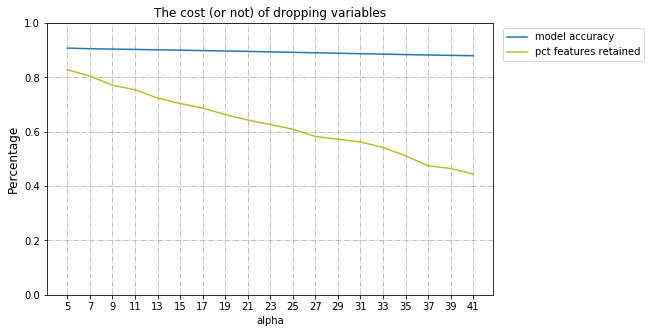

In [10]:
regressions = []
scores = []
alphas = np.arange(5, 42, 2)

for a in alphas:
    regression = lm.Lasso(alpha=a, 
                          fit_intercept=True, 
                          normalize=False, 
                          max_iter=10000
                         )\
                   .fit(X_scaled, train_Y)
    regressions.append(regression)
    scores.append(regression.score(X_scaled, train_Y))

# plt.figure()
fig, ax = plt.subplots(figsize=(8, 5))
color = 'tab:blue'
line1 = ax.plot(alphas, scores, color=color, label='model accuracy')
plt.xticks(alphas)
plt.grid(True, linestyle='-.')
plt.xlabel('alpha')
plt.ylim([0, 1])
plt.ylabel('Percentage', color='black', size=12)
plt.title('The cost (or not) of dropping variables')

# collections.Counter returns dict with counts of each value in list. Using to get counts of 0
coefs = [collections.Counter(x.coef_)[0]/len(x.coef_) for x in regressions]

color = 'tab:olive'
line2 = ax.plot(alphas, 1 - np.array(coefs), color=color, label='pct features retained')
# plt2.set_ylabel('Fraction of features retained', color=color, size=12)
plt.legend(bbox_to_anchor=(1.01,1))
plt.show();

In [11]:
print(f"This plot shows that a penalty factor of alpha = 41 which drops about {np.round(coefs[-1]*100,0).astype(int)}% of the input features \nwould cost a {np.round((scores[-1] - scores[0]) * 100, 2)} percentage point drop in accuracy. Below we'll compare the performance of the\nlasso with alpha = 5 and alpha = 41.")


This plot shows that a penalty factor of alpha = 41 which drops about 56% of the input features 
would cost a -2.81 percentage point drop in accuracy. Below we'll compare the performance of the
lasso with alpha = 5 and alpha = 41.


In [12]:
# Lasso Regression with alpha=19
a = 41
lasso_41 = lm.Lasso(alpha=a, fit_intercept=True, normalize=False, max_iter=10000).fit(X_scaled, train_Y)
lasso_41.score(X_scaled, train_Y)

0.8796169035485153

### Evaluate generalizability of lasso and simple linear regression

In [13]:
test_X_standardized = scalar.transform(test_X)
test_X_scaled = normalize(test_X_standardized, norm='l2')

/Users/aditinabar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [28]:
model_performance = pd.DataFrame(data={'model': ['OLS', 'OLS', 'LASSO','LASSO-41'], 
                                       'data':['raw, unprocessed data', 'standardized and normalized data', 'standardized and normalized data', 'standardized and normalized data'],
                                       'R**2_train': [reg_lm_raw.score(train_X, train_Y), reg_lm_scaled.score(X_scaled, train_Y),reg_lasso.score(X_scaled, train_Y), lasso_41.score(X_scaled, train_Y),],
                                       'R**2_test': [reg_lm_raw.score(test_X, test_Y), reg_lm_scaled.score(test_X_scaled, test_Y), reg_lasso.score(test_X_scaled, test_Y), lasso_41.score(test_X_scaled, test_Y)]
                                      })
model_performance

,model,data,R**2_train,R**2_test
0,OLS,"raw, unprocessed data",0.943141,3.661155e-01
1,OLS,standardized and normalized data,0.918742,-9.887139e+20
2,LASSO,standardized and normalized data,0.907732,8.488639e-01
3,LASSO-41,standardized and normalized data,0.879617,8.437122e-01


The R^2 value of the linear regression is deep in the negatives as we can see. The model's performance on the scaled test set appears to have suffered more of a performance hit than the LASSO analysis, which dropped 50% of the input features. 

### Singular Value Decomposition

This section will explore using SVD as a method to perform dimensionality reduction on the data and using the resulting components as inputs to a linear regression.

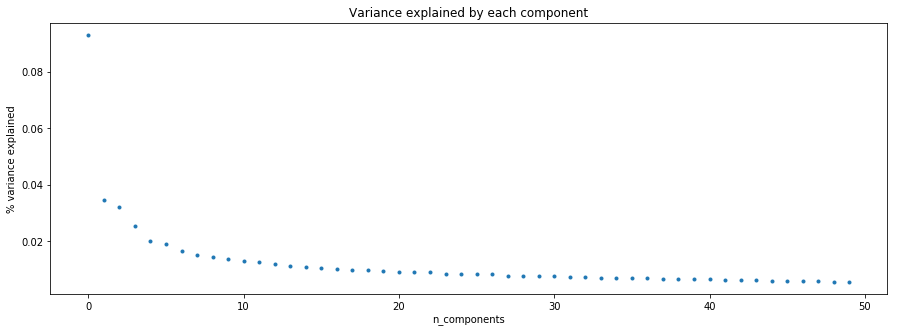

In [15]:
n_components = 50

SVD = TruncatedSVD(n_components=n_components, algorithm='randomized', random_state=7)
SVD.fit(X_scaled)
X_SVD_transformed = SVD.transform(X_scaled)
plt.figure(figsize=(15, 5), facecolor='w', edgecolor='k')
plt.plot(range(n_components), SVD.explained_variance_ratio_, '.')
plt.title('Variance explained by each component')
plt.xlabel('n_components')
plt.ylabel('% variance explained')
plt.show();

In [16]:
# fit linear regression on first 10 components given by the SVD's singular values.
SVD_10 = pd.DataFrame(X_SVD_transformed).iloc[:,0:11]
reg_SVD = lm.LinearRegression().fit(SVD_10, train_Y)
print('Prediction score of simple linear regression on raw data: ', reg_SVD.score(SVD_10, train_Y))
print(f"\nInterestingly, the first 10 components explain only {np.round(sum(SVD.explained_variance_ratio_[:11]) * 100, 2)}% of the variance in the data,\nyet yield a model accuracy of {np.round(reg_SVD.score(SVD_10, train_Y), 4)}.\n\nI\'ll include another 20 components to see if that will improve model performance.")

Prediction score of simple linear regression on raw data:  0.7196069916834062

Interestingly, the first 10 components explain only 29.57% of the variance in the data,
yet yield a model accuracy of 0.7196.

I'll include another 20 components to see if that will improve model performance.


In [17]:
SVD_30 = pd.DataFrame(X_SVD_transformed).iloc[:,0:31]
reg_SVD_30 = lm.LinearRegression().fit(SVD_30, train_Y)
print('Prediction score of simple linear regression on raw data: ', reg_SVD_30.score(SVD_30, train_Y))
print('By including 20 more components in this regression, the model is able to capture 4% more variance in the ')


Prediction score of simple linear regression on raw data:  0.7542708330011957
By including 20 more components in this regression, the model is able to capture 4% more variance in the 


### Evaluate generalizability of linear regression + SVD 
ie. the performance of a linear regression on the singular vectors given by the Singular Value Decomposition

In [18]:
SVD_test = SVD.transform(test_X_scaled)
SVD_10_test = pd.DataFrame(SVD_test).iloc[:,0:11]
SVD_30_test = pd.DataFrame(SVD_test).iloc[:,0:31]

In [29]:
model_performance = model_performance.append({'model': 'SVD-10', 
                          'data':'first 10 components given by the singular values', 
                          'R**2_train':reg_SVD.score(SVD_10, train_Y),
                          'R**2_test':reg_SVD.score(SVD_10_test, test_Y)},
                        ignore_index=True)
model_performance = model_performance.append({'model': 'SVD-30', 
                          'data':'first 30 components given by the singular values', 
                          'R**2_train':reg_SVD_30.score(SVD_30, train_Y),
                          'R**2_test':reg_SVD_30.score(SVD_30_test, test_Y)},
                        ignore_index=True).drop_duplicates()
model_performance

,model,data,R**2_train,R**2_test
0,OLS,"raw, unprocessed data",0.943141,3.661155e-01
1,OLS,standardized and normalized data,0.918742,-9.887139e+20
2,LASSO,standardized and normalized data,0.907732,8.488639e-01
3,LASSO-41,standardized and normalized data,0.879617,8.437122e-01
4,SVD-10,first 10 components given by the singular values,0.719607,7.835745e-01
5,SVD-30,first 30 components given by the singular values,0.754271,7.905784e-01


### Regression with ElasticNet

In [ ]:
# Elasticnet: uses both the Ridge and Lasso penalties. Drawback of Lasso is that if there are a number of correlated 
# variables, it will only select one, and deselect for the rest. 

\begin{equation*}
{\hat {\beta }}\equiv {\underset {\beta }{\operatorname {argmin} }}(\|y-X\beta \|^{2}+\lambda _{2}\|\beta \|^2_2+\lambda _{1}\|\beta \|_{1})
\end{equation*}

scikit-learn's elasticnet implementation allows you to attribute weights (which sum to 1) to each of the penalties. Setting $l1_{ratio} = 1 $ will apply the Lasso, or $L1$ norm, penalty and setting $l1_{ratio} = 0$ will apply the Ridge, or $L2$ norm penalty. When $0 < l1_{ratio} < 1$ will apply some fraction of both penalties. The following is the objective function the implementation aims to minimize

\begin{equation*}
{\frac{1}{2*n_{samples}} * ||y - X\beta||^2_2
+ \alpha * l1_{ratio} * ||\beta||_1
+ 0.5 * \alpha * (1 - l1_{ratio}) * ||\beta||^2_2}
\end{equation*}

In [20]:
# Start with the default implementation on the scaled input used for Lasso above.
# The data must be Fortran-contiguous. Checking X_scaled.flags verifies that this condition is met.

ElastNet = lm.ElasticNet(random_state=17)
ElastNet.fit(X_scaled, train_Y)
ElastNet.score(X_scaled, train_Y)
predictions_elastnet = ElastNet.predict(X_scaled)
testpredictions_elastnet = ElastNet.predict(test_X_scaled)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=17, selection='cyclic', tol=0.0001, warm_start=False)

0.15250643532854713

In [21]:
mean_squared_error(testpredictions_elastnet, test_Y)

6030123220.825118

We're looking at pretty terrible performance out of the box. Let's tune the model.

In [22]:
# Increase max_iter to give the model the opportunity to converge
# Increase alpha from 1 to 10
# increase the weight of the lasso penalty (the l1 norm)

ElastNet2 = lm.ElasticNet(alpha=10,l1_ratio=.75, fit_intercept=True, selection='cyclic', max_iter=1000000, tol=0.000001, random_state=17)
ElastNet2.fit(train_X, train_Y)
ElastNet2.score(train_X, train_Y)
testpredictions_elastnet2 = ElastNet2.predict(test_X)

ElasticNet(alpha=5, copy_X=True, fit_intercept=True, l1_ratio=0.75,
      max_iter=1000000, normalize=False, positive=False, precompute=False,
      random_state=17, selection='cyclic', tol=1e-06, warm_start=False)

0.7696919618869859

In [ ]:
ElastNet2.n_iter_

In [23]:
mean_squared_error(testpredictions_elastnet2, test_Y)

1346111153.6910222

In [32]:
to_append = pd.Series(['ElasticNet', 
                       'standardized and normalized data', 
                       ElastNet.score(X_scaled, train_Y), 
                       ElastNet.score(test_X_scaled, test_Y)], 
                      index=model_performance.columns)
model_performance = model_performance.append(to_append, ignore_index=True)

to_append = pd.Series(['ElasticNet', 
                       'raw, unprocessed data', 
                       ElastNet2.score(train_X, train_Y), 
                       ElastNet2.score(test_X, test_Y)], 
                      index=model_performance.columns)
model_performance = model_performance.append(to_append, ignore_index=True)
model_performance

model_performance = model_performance.append({'model': ['ElasticNet', 'ElasticNet'], 
                          'data':['standardized and normalized data', 'raw, unprocessed data'], 
                          'R**2_train':[ElastNet.score(X_scaled, train_Y), ElastNet2.score(train_X, train_Y)],
                          'R**2_test':[ElastNet.score(test_X_scaled, test_Y), ElastNet2.score(test_X, test_Y)]},
                        ignore_index=True)

,model,data,R**2_train,R**2_test
0,OLS,"raw, unprocessed data",0.943141,3.661155e-01
1,OLS,standardized and normalized data,0.918742,-9.887139e+20
2,LASSO,standardized and normalized data,0.907732,8.488639e-01
3,LASSO-41,standardized and normalized data,0.879617,8.437122e-01
4,SVD-10,first 10 components given by the singular values,0.719607,7.835745e-01
5,SVD-30,first 30 components given by the singular values,0.754271,7.905784e-01
6,ElasticNet,standardized and normalized data,0.152506,1.560576e-01


In [25]:
model_performance

,model,data,R**2_train,R**2_test
0,OLS,"raw, unprocessed data",0.943141,0.366115
1,OLS,standardized and normalized data,0.918742,-9.88714e+20
2,LASSO,standardized and normalized data,0.907732,0.848864
3,LASSO-41,standardized and normalized data,0.879617,0.843712
4,SVD-10,first 10 components given by the singular values,0.719607,0.783574
5,SVD-30,first 30 components given by the singular values,0.754271,0.790578
6,"[ElasticNet, ElasticNet]","[standardized and normalized data, raw, unproc...","[0.15250643532854713, 0.7696919618869859]","[0.15605759218134252, 0.8116057920152906]"


### Regression with Random Forests

So far we have looked at various types of linear models including some with caveats. Next we'll explore the performance of a non-linear model - Random Forests.

In [ ]:
RandomForestRegressor

# Future work: TBD

- elasticnet
- gradient boosting
- neural net
- figure out how to hide cells which contain calculations in the text, and cannot be run via Markdown